In [1]:
!pip install pycocotools
!pip install torchmetrics

In [1]:
import LocoFasterRCNN
import torch

faster_rcnn = LocoFasterRCNN.LocoFasterRCNN()
model = faster_rcnn.get_model()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Step 2: Load the state_dict into the model
model.to(device)
mode_path = "/notebooks/models/fasterRCNN5/fasterRCNN_valloss_0.89159_t_1687397777_epoch8.pth"
model.load_state_dict(torch.load(mode_path))

<All keys matched successfully>

In [2]:
import LocoUtils

#load data
# Example Usage:
base_img_folder = '/notebooks/dataset/loco_new/images'
annotations_folder = '/notebooks/dataset/loco_new/annotations'
loader = LocoUtils.LocoDatasetLoader(base_img_folder, annotations_folder)
test_data_loader = loader.get_test(batch_size=4)

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [5]:
from tqdm import tqdm
# Store predictions and ground truths

# predictions and ground truths are stored in:
#   - preds: list of [image_id, class_id, score, x_min, y_min, x_max, y_max]
#   - gt: list of [image_id, class_id, x_min, y_min, x_max, y_max]
preds = []
gt = []

model.eval()
with torch.no_grad():
    for images, targets in tqdm(test_data_loader):
        # Move images to the device
        images = list(image.to(device) for image in images)
        
        # Get model predictions
        outputs = model(images)
        
        # Collect predictions and ground truth
        for i, output in enumerate(outputs):
            image_id = targets[i]["image_id"].item()
            for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
                preds.append([image_id, label.item(), score.item(), *box.tolist()])
            
            for box, label in zip(targets[i]["boxes"], targets[i]["labels"]):
                gt.append([image_id, label.item(), *box.tolist()])

100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


  0%|          | 0/301 [00:00<?, ?it/s]

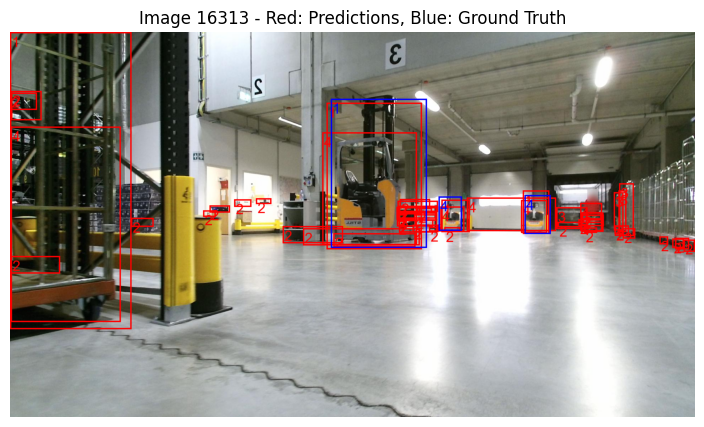

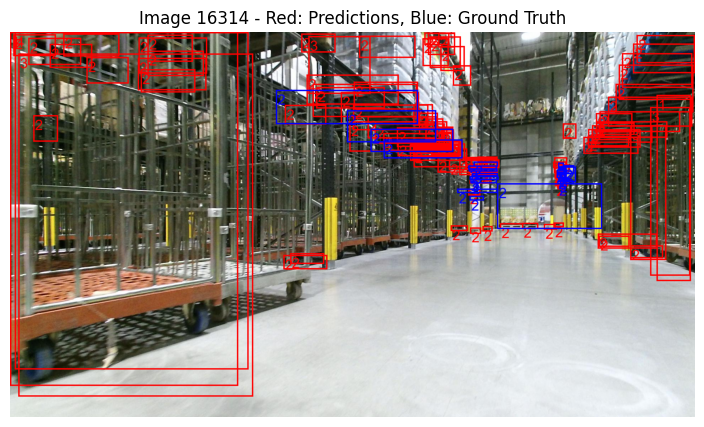

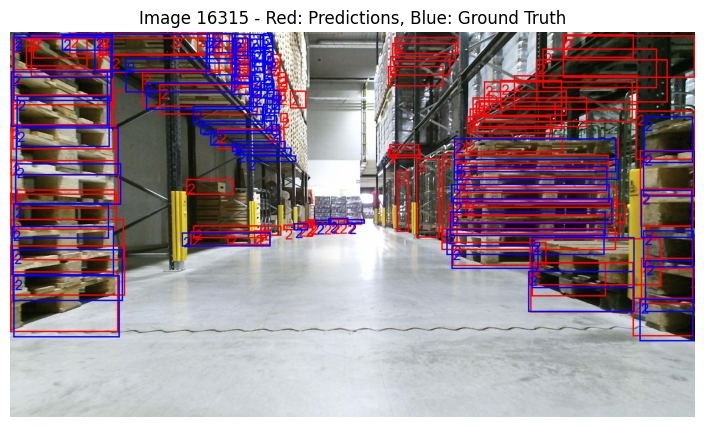

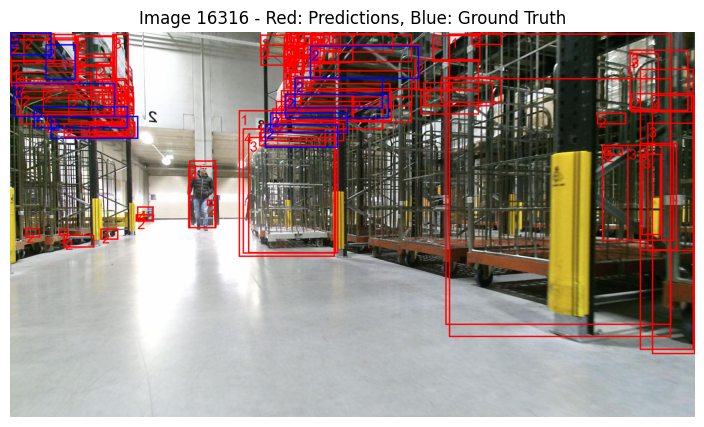

  0%|          | 1/301 [00:05<26:30,  5.30s/it]

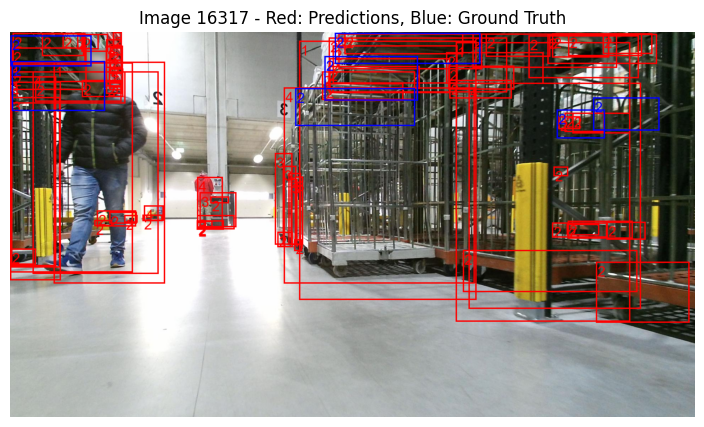

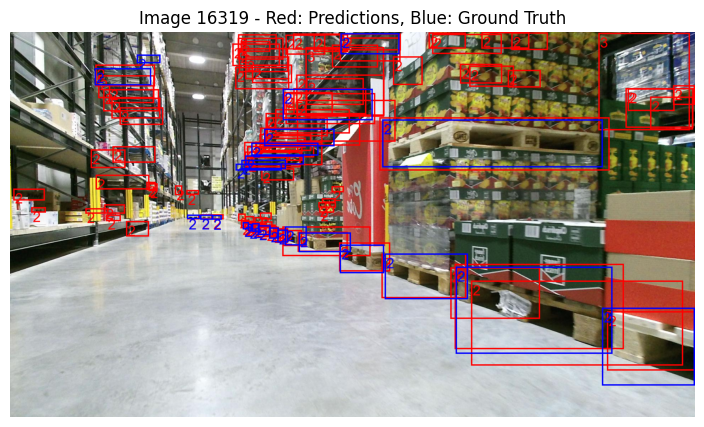

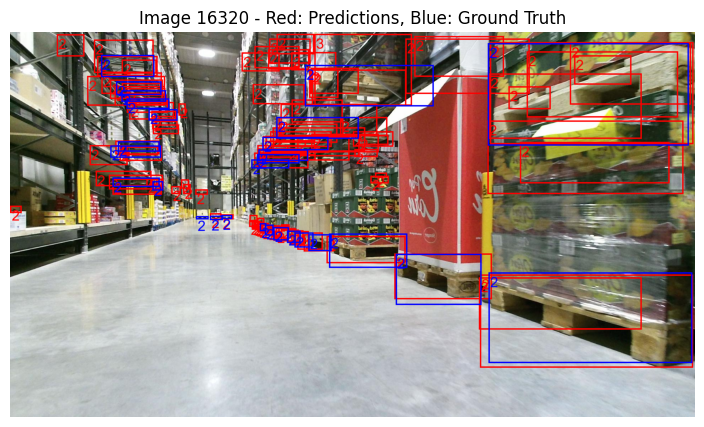

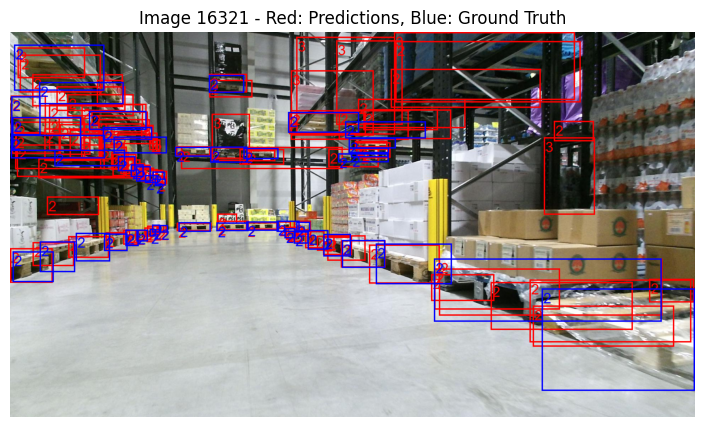

  1%|          | 2/301 [00:10<26:14,  5.26s/it]


In [11]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from tqdm import tqdm

# preds and gt lists for collecting predictions and ground truths
preds = []
gt = []

# Set model to evaluation mode
model.eval()
count = 0
# Loop through each image
with torch.no_grad():
    for images, targets in tqdm(test_data_loader):
        count +=1
        if count > 2:
            break;
        # Move images to the device
        images = list(image.to(device) for image in images)

        # Get model predictions
        outputs = model(images)

        # Collect predictions and ground truth
        for i, output in enumerate(outputs):
            image_id = targets[i]["image_id"].item()
            pil_image = images[i]

            # Collect predictions
            pred_labels = []  # store the labels of predictions
            for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
                preds.append([image_id, label.item(), score.item(), *box.tolist()])
                pred_labels.append(str(label.item()))  # add label to the list
            
            # Collect ground truths
            gt_labels = []  # store the labels of ground truths
            for box, label in zip(targets[i]["boxes"], targets[i]["labels"]):
                gt.append([image_id, label.item(), *box.tolist()])
                gt_labels.append(str(label.item()))  # add label to the list
            
            # Drawing bounding boxes on images
            # Convert image to uint8
            #pil_image = pil_image.to(torch.uint8)
            # Convert image to uint8
            pil_image = (pil_image * 255).byte()
            
            # Get the bounding boxes for current image
            pred_boxes = torch.tensor([p[3:] for p in preds if p[0] == image_id])
            gt_boxes = torch.tensor([g[2:] for g in gt if g[0] == image_id])
            
            # Draw predicted bounding boxes in red
            num_pred_boxes = pred_boxes.shape[0]
            red_colors = ['red'] * num_pred_boxes
            image_with_boxes = draw_bounding_boxes(pil_image, pred_boxes, labels=pred_labels, width=4, colors=red_colors,font = "/notebooks/assets/ARIAL.TTF", font_size = 40)
            # Draw ground truth bounding boxes in blue
            num_gt_boxes = gt_boxes.shape[0]
            blue_colors = ['blue'] * num_gt_boxes
            image_with_boxes = draw_bounding_boxes(image_with_boxes, gt_boxes, labels=gt_labels, width=4, colors=blue_colors,font = "/notebooks/assets/ARIAL.TTF",font_size = 40)
            
            # Convert the tensor with bounding boxes to PIL Image for displaying
            pil_image_with_boxes = to_pil_image(image_with_boxes)
            
            # Display the image
            plt.figure(figsize=(10, 5))
            plt.imshow(pil_image_with_boxes)
            plt.title(f"Image {image_id} - Red: Predictions, Blue: Ground Truth")
            plt.axis("off")
            plt.show()

In [13]:
from collections import Counter

# Extract the class_ids from the predictions and ground truths
pred_class_ids = [entry[1] for entry in preds]
gt_class_ids = [entry[1] for entry in gt]

'''
3=>0 small_load_carrier
5=>1 forklift
7=>2 pallet
10=>3 stillage
11=>4 pallet_truck
'''

# Count the occurrences of each class in predictions and ground truths
pred_counts = Counter(pred_class_ids)
gt_counts = Counter(gt_class_ids)

# Display the statistics
print(f"Class counts in predictions: {pred_counts}")
print(f"Class counts in ground truths: {gt_counts}")

# Calculate and display the percentage for each class
for class_id, gt_count in gt_counts.items():
    pred_count = pred_counts.get(class_id, 0)  # Get the count from predictions, 0 if not present
    percentage = (pred_count / gt_count) * 100
    print(f"Class {class_id}: {percentage:.2f}% of ground truth objects were detected")

print(len(preds))
count = 0
for x in preds:
    print(x)
    count+=1
    if count > 3:
        break
        
print(len(gt))
count = 0
for x in gt:
    print(x)
    count+=1
    if count > 3:
        break
# Assume you have the following lists:
# preds: list of [image_id, class_id, score, x_min, y_min, x_max, y_max]
# gt: list of [image_id, class_id, x_min, y_min, x_max, y_max]

Class counts in predictions: Counter({2: 101439, 3: 3145, 4: 2397, 1: 1910})
Class counts in ground truths: Counter({2: 39022, 4: 559, 1: 119, 3: 29})
Class 1: 1605.04% of ground truth objects were detected
Class 4: 428.80% of ground truth objects were detected
Class 2: 259.95% of ground truth objects were detected
Class 3: 10844.83% of ground truth objects were detected
108891
[16313, 4, 0.8289207220077515, 1432.8958740234375, 471.2381896972656, 1505.9693603515625, 563.1688232421875]
[16313, 2, 0.8012778162956238, 1090.7672119140625, 487.4429016113281, 1195.76318359375, 506.96527099609375]
[16313, 4, 0.7251814603805542, 1206.28515625, 489.8791809082031, 1273.9183349609375, 559.84814453125]
[16313, 4, 0.7234979867935181, 875.7825927734375, 281.27716064453125, 1140.9901123046875, 597.1665649414062]
39729
[16313, 1, 899.0, 187.0, 1168.0, 605.0]
[16313, 4, 1442.0, 457.0, 1515.0, 566.0]
[16313, 4, 1201.0, 461.0, 1266.0, 557.0]
[16314, 2, 1365.0, 424.0, 1659.0, 552.0]


In [6]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Convert the preds list to the expected format
formatted_preds = []
image_preds = {}
for image_id, class_id, score, x_min, y_min, x_max, y_max in preds:
    if image_id not in image_preds:
        image_preds[image_id] = {"boxes": [], "scores": [], "labels": []}
    image_preds[image_id]["boxes"].append([x_min, y_min, x_max, y_max])
    image_preds[image_id]["scores"].append(score)
    image_preds[image_id]["labels"].append(class_id)

for image_id, data in image_preds.items():
    formatted_preds.append({
        "boxes": torch.tensor(data["boxes"]),
        "scores": torch.tensor(data["scores"]),
        "labels": torch.tensor(data["labels"], dtype=torch.int)
    })

# Convert the gt list to the expected format
formatted_gt = []
image_gt = {}
for image_id, class_id, x_min, y_min, x_max, y_max in gt:
    if image_id not in image_gt:
        image_gt[image_id] = {"boxes": [], "labels": []}
    image_gt[image_id]["boxes"].append([x_min, y_min, x_max, y_max])
    image_gt[image_id]["labels"].append(class_id)

for image_id, data in image_gt.items():
    formatted_gt.append({
        "boxes": torch.tensor(data["boxes"]),
        "labels": torch.tensor(data["labels"], dtype=torch.int)
    })

In [7]:
# Compute mAP
metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', num_classes=5, class_metrics=True)
metric.update(formatted_preds, formatted_gt)
map_score = metric.compute()

In [8]:
from pprint import pprint

def format_value(v):
    if torch.is_tensor(v):
        if v.numel() == 1:
            return "{:.5f}".format(v.item())
        else:
            return ["{:.5f}".format(item) for item in v.tolist()]
    elif isinstance(v, float):
        return "{:.5f}".format(v)
    else:
        return v

formatted_results = {k: format_value(v) for k, v in map_score.items()}

pprint(formatted_results)

{'map': '0.09470',
 'map_50': '0.24305',
 'map_75': '0.05224',
 'map_large': '0.13385',
 'map_medium': '0.05293',
 'map_per_class': ['0.02190', '0.18550', '0.00048', '0.17093'],
 'map_small': '0.03892',
 'mar_1': '0.10109',
 'mar_10': '0.19564',
 'mar_100': '0.24508',
 'mar_100_per_class': ['0.27563', '0.29169', '0.09655', '0.31646'],
 'mar_large': '0.31899',
 'mar_medium': '0.14824',
 'mar_small': '0.09052'}


"/notebooks/models/fasterRCNN5/fasterRCNN_valloss_0.89159_t_1687397777_epoch8.pth"
{'map': '0.09470',
 'map_50': '0.24305',
 'map_75': '0.05224',
 'map_large': '0.13385',
 'map_medium': '0.05293',
 'map_per_class': ['0.02190', '0.18550', '0.00048', '0.17093'],
 'map_small': '0.03892',
 'mar_1': '0.10109',
 'mar_10': '0.19564',
 'mar_100': '0.24508',
 'mar_100_per_class': ['0.27563', '0.29169', '0.09655', '0.31646'],
 'mar_large': '0.31899',
 'mar_medium': '0.14824',
 'mar_small': '0.09052'}


"/notebooks/models/fasterRCNN/fasterRCNN_epoch3_valloss_0.90050_t_1687367945.pth"
{'map': '0.08805',
 'map_50': '0.23073',
 'map_75': '0.04579',
 'map_large': '0.12462',
 'map_medium': '0.04920',
 'map_per_class': ['0.01376', '0.18839', '0.00069', '0.14938'],
 'map_small': '0.04063',
 'mar_1': '0.08935',
 'mar_10': '0.19161',
 'mar_100': '0.24153',
 'mar_100_per_class': ['0.21008', '0.29297', '0.14483', '0.31825'],
 'mar_large': '0.31799',
 'mar_medium': '0.14238',
 'mar_small': '0.08812'}
 
 
 "/notebooks/models/fasterRCNN3/fasterRCNN_valloss_0.88698_t_1687386756_epoch1.pth"
 {'map': '0.08387',
 'map_50': '0.22305',
 'map_75': '0.04149',
 'map_large': '0.12118',
 'map_medium': '0.04208',
 'map_per_class': ['0.02313', '0.17250', '0.00195', '0.13789'],
 'map_small': '0.03233',
 'mar_1': '0.10521',
 'mar_10': '0.19681',
 'mar_100': '0.24495',
 'mar_100_per_class': ['0.25042', '0.28197', '0.16207', '0.28533'],
 'mar_large': '0.33204',
 'mar_medium': '0.11760',
 'mar_small': '0.09047'}